# 03 Algorithms

## 3.13 Dueling Deep Q-Network

### Dueling Deep Q-Network

在强化学习中，我们将动作价值$Q(s,a)$减去状态价值$V(s)$称为优势$A(s,a)$：
$$
A(s,a) = Q(s,a)-V(s)
$$
即在一个状态$s$下，所有动作的优势值之和为0，因为状态价值$V(s)$的定义是在状态$s$下所有动作价值的期望。

与Deep Q-Network不同，Dueling Deep Q-Network将$Q$值分成两部分：状态值$V(s)$和动作优势$A(s,a)$，即$Q(s,a)=V(s)+A(s,a)$。其中，$V(s)$表示状态$s$的价值——即在状态$s$下，执行任何动作的期望回报；$A(s,a)$表示在状态$s$下执行动作$a$的优势——即执行动作$a$相比平均水平的超额回报。将二者分开，能够使智能体更好地处理与动作关联较小的状态，并使得网络更有针对性。

$Dueling \ Deep \ Q-Network$的网络结构定义如下：
$$
Q_{\eta, \alpha, \beta}(s,a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s,a)-\frac{1}{|A|}\sum_{a'}A_{\eta, \beta}(s,a')
$$
或
$$
Q_{\eta, \alpha, \beta}(s,a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s,a)-\max_{a'}A_{\eta, \beta}(s,a')
$$
其中，$\alpha$和$\beta$分别表示状态值网络和动作优势网络（表示采取不同动作的差异）的参数；$\eta$表示状态价值网络和动作优势网络共享的网络参数，一般用来提取特征的前几层；

减去的动作优势最大值或均值是强制最优动作的优势函数的实际输出为0，这样做的目的在于保证网络的稳定性（即使得网络在某些状态下所有动作的价值都是一个常数，也能保证网络的输出训练稳定——因为在$Q(s,a)=V(s)+A(s,a)$中即使动作价值$Q$值相同，$V$和$A$也可能不同，因此存在多解，从而导致网络训练不稳定）。

在这样的模型结构下，不再让神经网络直接输出动作价值$Q$值，而是训练神经网络的最后基层的两个分支，分别输出状态价值$V(s)$和动作优势函数$A(s,a)$，再求和得到动作价值$Q$。

<center>
    <img src="../Images/dueling deep q-network.png" alt="图8.1: Inverted Pendulum">
</center>

为什么Dueling Deep Q-Network会比Deep Q-Network好？
部分原因在于为什么Dueling Deep Q-Network能更高效学习状态价值函数。每一次更新时，状态价值$V$都会被更新，这也会影响到其它动作价值$Q$。而传统的Deep Q-Network只会更新某个动作价值$Q$，其他动作的$Q$值就不会更新。因此，为什么Dueling Deep Q-Network能够更加频繁、准确地学习状态价值函数。

**一个例子：**

一个简单游戏，只有两个动作，向左或向右移动。假设智能体在状态$s$下执行向左或者向右动作$a$的回报都为10分，在状态$s$下向左能获得2分的超额回报，向右没有超额回报。那么$Q$值可以表示为：
$$
Q(s,a)=10+\left\{
\begin{array}{ll}
2-\frac{2+0}{2} & \text{if }a=\text{left}\\
0-\frac{2+0}{2} & \text{if }a=\text{right}
\end{array}
\right.
$$

### Dueling Deep Q-Network Algorithm (同Deep Q-Network Algorithm，差异在网络架构上)

目标：从遵循行为策略$\pi_behavior$生成的经验数据中学习一个目标网络，用于近似最优动作价值函数$Q(s, a)$
- 初始化：一个是主网络($Q_{w}$)，另一个是目标网络($Q_{w'}$)、行为策略($\pi_{behavior}$)和$\mathcal{B} = \{(s, a, r, s')\}_{i=1}^{N}$、目标网络更新频率$C$、步长$\alpha$、折扣因子$\gamma$和探索率$\epsilon$
- $for \ e = 1 \rightarrow E \ do$：
- $\quad$ 获取环境初始状态$s$
- $\quad$ $for \ t = 1 \rightarrow T \ do$：
- $\quad\quad$ 根据主网络$Q_w(s, a)$以$\epsilon-Greedy$策略选择动作$a_t$
- $\quad\quad$ 执行动作$a_t$并观察环境反馈$r_t$和下一状态$s_{t+1}$
- $\quad\quad$ 将$(s_t, a_t, r_t, s_{t+1})$存入经验回放池$\mathcal{B}$
- $\quad\quad$ 若$\mathcal{B}$中样本数量超过预先设定的阈值，从经验回放池$\mathcal{B}$中随机抽取批量数据$\{s_j, a_j, r_j, s_{j+1}\}_{j=1}^{Batch}$，$Batch$为批量大小

- $\quad\quad$ 使用目标网络$Q_{w'}$计算目标值$y_j = r_j + \gamma \max_{a} Q_{w'}(s_{j+1}, a)$
- $\quad\quad$ 最小化损失函数$L = \frac{1}{N} \sum_{j=1}^N (y_j - Q_w(s_j, a_j))^2$，更新主网络$Q_w$
- $\quad\quad$ 若满足目标网络更新周期$C$，则更新目标网络$Q_{w'} = Q_w$
- $\quad$ $end \ for$
- $end \ for$

### Example

In [1]:
import time
import random
import collections

import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer:
    """ Experience Replay Buffer """

    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)


    def add(self, state, action, reward, next_state, done):
        """ Add Experience to Buffer """

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """ Sample a Batch of Experiences from Buffer """

        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        """ Return the Size of Buffer """

        return len(self.buffer)

In [3]:
class Qnetwork(nn.Module):
    """ Deep Q-Network """

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(nn.functional.relu(self.fc1(x)))
        V = self.fc_V(nn.functional.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

In [4]:
def get_device():
    """ Get device """

    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [5]:
class DeepQNetwork:
    """ Deep Q-Network Algorithm """

    def __init__(self, env, state_dim, action_dim, hidden_dim=64, learning_rate=0.01, gamma=0.99, epsilon=0.1, epsilon_decay=0.99, target_update_freq=2, device=None, buffer_capacity=10000):
        """ Initialize Deep Q-Network """

        self.env = env
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq

        self.device = device
        if self.device is None:
            self.device = get_device()

        # Initialize buffer
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)

        self.main_network = Qnetwork(state_dim, hidden_dim, action_dim).to(device)
        self.target_network = Qnetwork(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.main_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

        self.steps = 0
        self.returns = []

    def best_action(self, state):
        """ Best action for a given state according to the current network """
        with torch.no_grad():
            # Check if the state is empty or has the wrong shape
            if state is None or len(state) == 0 or len(state) != self.state_dim:
                raise ValueError(f"State is invalid: {state}")

            # Convert state to tensor
            state = torch.tensor(np.array([state]), dtype=torch.float32).to(self.device)

            # Ensure the state has the correct shape
            if state.shape != (1, self.state_dim):
                raise ValueError(f"State has incorrect shape: {state.shape}")

            # Get action from Q-network
            action = self.main_network(state).argmax().item()

        return action


    def take_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            action = self.best_action(state)

        return action

    def update(self, batch):
        """ Update the Q-values using a batch of experiences """

        states = torch.tensor(batch['states'], dtype=torch.float32).to(self.device)
        actions = torch.tensor(batch['actions'], dtype=torch.long).to(self.device)
        rewards = torch.tensor(batch['rewards'], dtype=torch.float32).to(self.device)
        next_states = torch.tensor(batch['next_states'], dtype=torch.float32).to(self.device)
        dones = torch.tensor(batch['dones'], dtype=torch.float32).to(self.device)

        # Compute Q-values for the current states and actions
        current_q_values = self.main_network(states).gather(1, actions.view(-1, 1))
        # Compute max target Q-values for the next states using the target network
        max_target_q_values = self.target_network(next_states).max(axis=1)[0].view(-1, 1)
        # Compute the target Q-values using the Bellman equation with discount factor gamma and rewards
        targets = rewards.view(-1, 1) + self.gamma * max_target_q_values * (1 - dones.view(-1, 1))
        # Compute the loss using mean squared error between current Q-values and target Q-values
        loss = self.criterion(current_q_values, targets)
        # Backpropagate the loss and update the network parameters using Adam optimizer with learning rate lr
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Update the target network parameters using a soft update with tau factor to track slowly changing targets
        if self.target_update_freq > 0 and self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.main_network.state_dict())

        self.steps += 1

    def train(self, epochs=100, batch_size=32):
        """ Train the DQN agent on the given number of epochs with a batch size """

        for i in range(10):
            with tqdm(total=epochs // 10, desc=f"Iteration {i+1}") as pbar:
                for epoch in range(epochs // 10):
                    state, info = self.env.reset()

                    done = False
                    gamma_power = 1
                    episode_return = 0
                    while not done:
                        action = self.take_action(state)
                        next_state, reward, terminated, truncated, info = self.env.step(action)
                        done = terminated or truncated
                        self.replay_buffer.add(state, action, reward, next_state, done)
                        state = next_state

                        episode_return += reward * gamma_power
                        gamma_power *= self.gamma

                        if self.replay_buffer.size() >= batch_size:
                            state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(batch_size)

                            batch = {
                                "states": state_batch,
                                "actions": action_batch,
                                "rewards": reward_batch,
                                "next_states": next_state_batch,
                                "dones": done_batch
                            }
                            self.update(batch)

                    self.returns.append(episode_return)
                    if (epoch + 1) % 10 == 0:
                        pbar.set_postfix(
                            {
                                'epoch': epochs / 10 * i + epoch + 1,
                                'return': np.mean(self.returns),
                                'epsilon': self.epsilon
                            }
                        )
                    pbar.update(1)

                    self.epsilon *= self.epsilon_decay
                    self.epsilon = max(self.epsilon, 0.01)

    def visualize(self, delay=0.5):
        state, info = self.env.reset()
        done = False

        while not done:
            self.env.render()
            action = self.best_action(state)
            state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            time.sleep(delay)

        self.env.render()
        self.env.close()

In [6]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

In [7]:
name = 'CartPole-v1'
environment = gym.make(name, render_mode='rgb_array')
environment.reset()

(array([-0.01522439, -0.01051358, -0.0372603 ,  0.02170813], dtype=float32),
 {})

In [8]:
agent = DeepQNetwork(
    env=environment,
    state_dim=environment.observation_space.shape[0],
    action_dim=environment.action_space.n,
    hidden_dim=128,
    learning_rate=0.001,
    gamma=0.98,
    epsilon=1,
    epsilon_decay=0.995,
    target_update_freq=10,
    buffer_capacity=1000,
    device=get_device()
)

In [9]:
agent.train(
    epochs=1000,
    batch_size=128
)

Iteration 10: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it, epoch=1e+3, return=43.9, epsilon=0.01]


In [10]:
environment = gym.make(name, render_mode='human')
environment.reset()

agent.env = environment
agent.visualize()

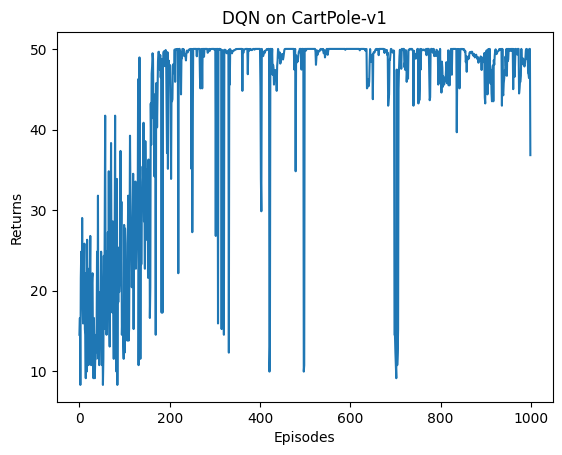

In [11]:
episodes = list(range(len(agent.returns)))
plt.plot(episodes, agent.returns)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(name))
plt.show()

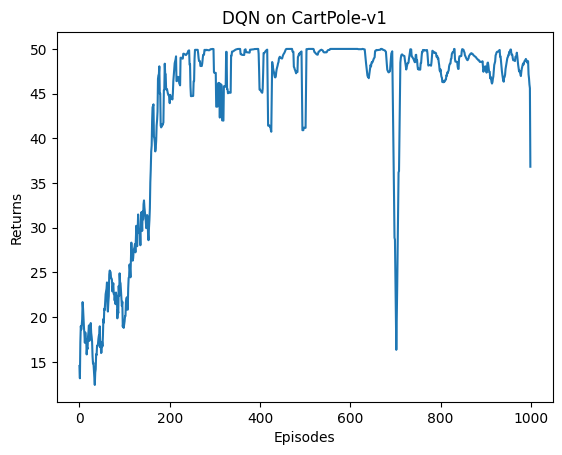

In [12]:
mv_return = moving_average(agent.returns, 9)
plt.plot(episodes, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(name))
plt.show()